# **Causal Analysis I & II - Basic**

1.	Proses matching dapat membantu causal analyst berdasarkan persamaan dari setiap profile yang match dari group treatment dengan group control. Sehingga cofounder tidak memiliki efek lagi karena secara profile sudah sama. Menemukan data yang serupa dalam satu dimensi (skor kecenderungan) jauh lebih mudah dari pada melakukannya di banyak dimensi (confounder). Hal tersebut sama dengan tentang metode Dimensi Reduction. propensity score adalah skor penyeimbang. Ini berarti, jika kita mencocokkan data berdasarkan propensity, distribusi pembaur antara data yang cocok akan cenderung serupa. 
Reference: https://towardsdatascience.com/propensity-score-matching-a0d373863eec

2.	Double ML lebik baik digunakan karena dapat mengukur heterogeneous/treatment effect tapi bukan rata-rata populasi tapi dapat mengetahui dampak setiap row secara lebih detail atau spesifik sedangkan double selection tidak dapat mengukur hal tersebut atau dapat dikatakan untuk double selection :
a.	tidak ada kovariat
b.	semua kemungkinan kovariat (ini menghasilkan multikolinearitas sempurna) hampir semua kemungkinan kovariat
c.	satu set kovariat terbatas (menebak beberapa dengan benar, tetapi menyertakan yang lain yang seharusnya tidak ada dalam model)
Atribut penting dari Double ML adalah bahwa kita tidak perlu menggunakan LASSO dan OLS untuk menghitung residu; alat lain seperti Random Forest, boosted tree, dan bahkan neural nets yang dalam juga dapat digunakan pada langkah pertama tersebut.
Reference : https://www.r-bloggers.com/2017/05/problems-of-causal-inference-after-selecting-of-controls/

3.	ATE ; average treatment effect dapat digunakan saat (ukuran populasi, mencari selisih dari outcome treatment dan without treatment kemudian dihitung rata-rata)
CATE: Conditional average treatment effect , menghitung tiap kategori dari yang dilakukan treatment (Tergantung kondisi, contohnya berdasarkan gender, Pendidikan,  dll), dapat memberikan insgint yang lebih detail dan yang memiliki group
LATE : Local Average treatment Effect dapat diestimasi oleh ratio estimasi efek intent-to-treat effect ( Kondisi dimana tidak menjalankan prosedur, biasanya terjadi di eksperiment akademik
Reference : https://egap.org/resource/10-things-to-know-about-the-local-average-treatment-effect/

4.	Untuk dapat menjelaskan metode mana yang dapat menjelaskan dampak dari akibat yaitu dengan metode evaluasi dengan mengagregasi voting dari dampaknya, 
Model interpretable machine learning dapat digunakan untuk analisis kausal : Kemampuan ML untuk menemukan korelasi lebih dari cukup (mis: prediksi harga, klasifikasi objek, penargetan yang lebih baik, dll.). Memang, sistem ML unggul dalam mempelajari hubungan antara data input dan prediksi output, tetapi kurang dalam penalaran tentang hubungan sebab-akibat atau perubahan lingkungan. Model ML yang dapat menangkap hubungan sebab akibat akan lebih dapat digeneralisasikan. Untuk model ML prediktif klasik untuk memberikan hasil kausal, fitur harus independen tidak hanya dari fitur lain dalam model, tetapi juga dari cofounder yang tidak teramati.
Reference :
https://towardsdatascience.com/be-careful-when-interpreting-predictive-models-in-search-of-causal-insights-e68626e664b6

# **Causal Analysis I & II - Advanced**


# **Install and Load Packages**

In [39]:
!pip install psmpy
!pip install pycausalimpact

In [2]:
# load data wrangling package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# statsmodels for linear/logistic regression and Granger causality test
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

# psmpy for propensity score modeling and plotting
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *

# causalimpact for intervention analysis
from causalimpact import CausalImpact

# **Load Dataset**

In [3]:
mindset = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/learning_mindset/learning_mindset.csv")

# **Propensity Score Matching**

In [5]:
#Check Data Sheet
mindset.head()

,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
0,76,1,0.277359,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
1,76,1,-0.449646,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
2,76,1,0.769703,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
3,76,1,-0.121763,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
4,76,1,1.526147,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757


**Penentuan variabel yang menjadi covariate (X), treatment (T), dan response (Y)**

The variable that becomes
a. covariate (X) =
**school_poverty**; because this variable has the meaning of why a person becomes poor, namely starting from the mindset, reference: https://katadata.co.id/sitinuraeni/berita/620636c38eedf/penyebab-kemiskinan-dan-dampak-yang-ditimbulkan  
**school_urbanicity**; because this variable provides an overview related to schoolid who has a place of origin or not so we can find out the impact of the schoolid place where the environment we live in whether it affects the mindset or not
**frst_in_family**; This variable is of course highly assumed to provide an argument that the first child in a family is usually more mature than the other children in a family,
b. treatment (T) = intervention.
c. response (Y) = achievement_score


In [41]:
mindset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10391 entries, 0 to 10390
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   schoolid                10391 non-null  int64  
 1   intervention            10391 non-null  int64  
 2   achievement_score       10391 non-null  int64  
 3   success_expect          10391 non-null  int64  
 4   ethnicity               10391 non-null  int64  
 5   gender                  10391 non-null  int64  
 6   frst_in_family          10391 non-null  int64  
 7   school_urbanicity       10391 non-null  int64  
 8   school_mindset          10391 non-null  float64
 9   school_achievement      10391 non-null  float64
 10  school_ethnic_minority  10391 non-null  float64
 11  school_poverty          10391 non-null  float64
 12  school_size             10391 non-null  float64
dtypes: float64(5), int64(8)
memory usage: 1.0 MB


In [42]:
mindset['achievement_score'] = mindset['achievement_score'].astype(int)
mindset['school_poverty'] = mindset['school_poverty'].astype(int)

In [43]:
mindset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10391 entries, 0 to 10390
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   schoolid                10391 non-null  int64  
 1   intervention            10391 non-null  int64  
 2   achievement_score       10391 non-null  int64  
 3   success_expect          10391 non-null  int64  
 4   ethnicity               10391 non-null  int64  
 5   gender                  10391 non-null  int64  
 6   frst_in_family          10391 non-null  int64  
 7   school_urbanicity       10391 non-null  int64  
 8   school_mindset          10391 non-null  float64
 9   school_achievement      10391 non-null  float64
 10  school_ethnic_minority  10391 non-null  float64
 11  school_poverty          10391 non-null  int64  
 12  school_size             10391 non-null  float64
dtypes: float64(4), int64(9)
memory usage: 1.0 MB


# **Data Inspection**

In [44]:
mindset_group = mindset.groupby('intervention').agg({
    'schoolid': 'nunique',
    'achievement_score': 'mean'
}).rename(columns={
    'schoolid': 'Total Users',
    'achievement_score': 'Average Risk Score'
})

In [45]:
mindset_group['Average Risk Score'].astype(int)

intervention
0    0
1    0
Name: Average Risk Score, dtype: int64

In [46]:
mindset_group.head()

,Total Users,Average Risk Score
intervention,,
0,76,-0.083060
1,76,0.207447


In [47]:
mindset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10391 entries, 0 to 10390
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   schoolid                10391 non-null  int64  
 1   intervention            10391 non-null  int64  
 2   achievement_score       10391 non-null  int64  
 3   success_expect          10391 non-null  int64  
 4   ethnicity               10391 non-null  int64  
 5   gender                  10391 non-null  int64  
 6   frst_in_family          10391 non-null  int64  
 7   school_urbanicity       10391 non-null  int64  
 8   school_mindset          10391 non-null  float64
 9   school_achievement      10391 non-null  float64
 10  school_ethnic_minority  10391 non-null  float64
 11  school_poverty          10391 non-null  int64  
 12  school_size             10391 non-null  float64
dtypes: float64(4), int64(9)
memory usage: 1.0 MB


# **Modeling**

The model used this time for causal analyst analysis uses the OLS Regression model. Using this model because they want to measure the P value or no significant impact on the treatment carried out.

In [48]:
# define Y and X variable
Y = mindset['achievement_score']
X = mindset['intervention']

In [49]:
X = sm.add_constant(X)
X

,const,intervention
0,1.0,1
1,1.0,1
2,1.0,1
3,1.0,1
4,1.0,1
...,...,...
10386,1.0,0
10387,1.0,0
10388,1.0,0
10389,1.0,0


In [50]:
# define model
model = sm.OLS(Y, X)

# fit model
result = model.fit()

In [51]:
# check model summary
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      achievement_score   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     431.2
Date:                Wed, 18 May 2022   Prob (F-statistic):           7.10e-94
Time:                        17:05:37   Log-Likelihood:                -10555.
No. Observations:               10391   AIC:                         2.111e+04
Df Residuals:                   10389   BIC:                         2.113e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0831      0.008    -10.404      0.000      -0.099      -0.067
intervention     0.2905      0.014     20.765      0.000       0.263       0.318
==============================================================================
Omnibus:                      510.764   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1536.740
Skew:                           0.205   Prob(JB):                         0.00
Kurtosis:                       4.839   Cond. No.                         2.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on model summary, we find that there is positive impact of intervention for growmindset! Number of intervention is still low 0.29. It doesn't make sense, clearly. But how to fix it? We can use psmpy to do matching and create propensity score so we can estimate the real effect of it.

# **Propensity Score Matching**

In [53]:
psm = PsmPy(
    mindset, 
    treatment = 'intervention', 
    indx='schoolid',
    exclude=['ethnicity', 'gender', 'school_mindset', 'school_achievement', 'school_ethnic_minority', 'success_expect', 'school_size']
)

Create balanced samples when fitting the logistic regression model.

In [54]:
psm.logistic_ps(balance=True)

Check propensity score for each user

In [55]:
psm.predicted_data

,schoolid,achievement_score,frst_in_family,school_urbanicity,school_poverty,propensity_score,propensity_logit,intervention
0,76,-2,1,4,0,0.506760,0.027041,1
1,76,-2,1,4,0,0.506760,0.027041,1
2,76,-2,1,4,0,0.506760,0.027041,1
3,76,-2,1,4,0,0.506760,0.027041,1
4,76,-2,1,4,0,0.506760,0.027041,1
...,...,...,...,...,...,...,...,...
10386,1,0,1,3,1,0.484455,-0.062201,0
10387,1,0,1,3,1,0.484455,-0.062201,0
10388,1,0,1,3,1,0.484455,-0.062201,0
10389,1,0,1,3,1,0.484455,-0.062201,0


Obtained the probability value of each user/id, for example in row index 0 ; has a 49% probability value of the treatment variable

Then we need to perform matching to eliminate the effect of confounders. Menggunakan KNN model karena untuk mengetahui jarak antar tiap user id dengan variable cofounder

In [56]:
psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=None)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Plot matching result

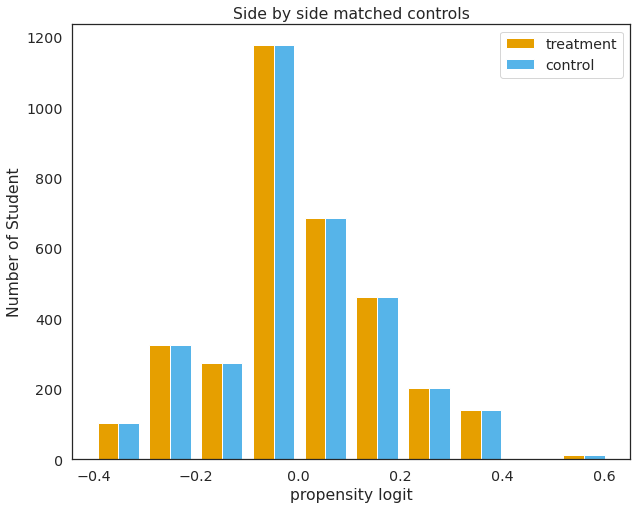

In [59]:
psm.plot_match(
    Ylabel = 'Number of Student',
    save = False
)

Distribution from treatment and control have been balance and might be forward !!

Check effect size of each covariates

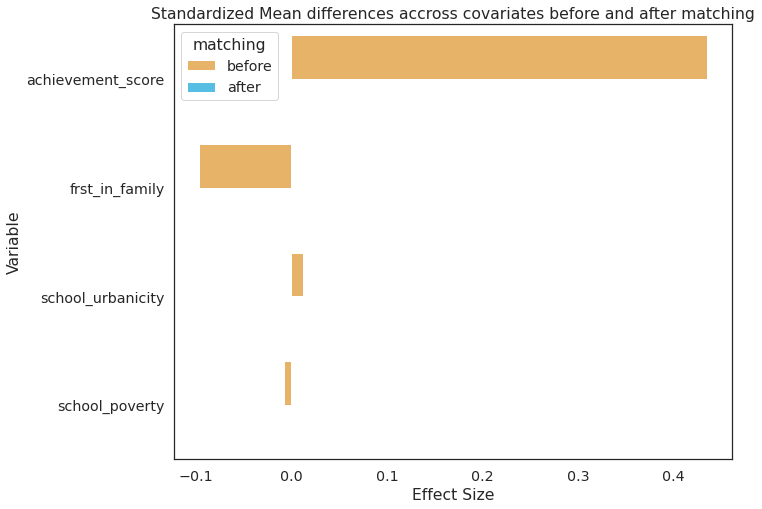

In [60]:
psm.effect_size_plot(save=False)

Due to intrepretable variable from achievement_score, success_expect, first_in_family and school_urbanicity have effect size 0 and match is clearly or could be ignored

Compare mathed data with our raw data

In [61]:
psm.df_matched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6768 entries, 0 to 6767
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   schoolid           6768 non-null   int64  
 1   achievement_score  6768 non-null   int64  
 2   frst_in_family     6768 non-null   int64  
 3   school_urbanicity  6768 non-null   int64  
 4   school_poverty     6768 non-null   int64  
 5   propensity_score   6768 non-null   float64
 6   propensity_logit   6768 non-null   float64
 7   intervention       6768 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 423.1 KB


In [62]:
mindset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10391 entries, 0 to 10390
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   schoolid                10391 non-null  int64  
 1   intervention            10391 non-null  int64  
 2   achievement_score       10391 non-null  int64  
 3   success_expect          10391 non-null  int64  
 4   ethnicity               10391 non-null  int64  
 5   gender                  10391 non-null  int64  
 6   frst_in_family          10391 non-null  int64  
 7   school_urbanicity       10391 non-null  int64  
 8   school_mindset          10391 non-null  float64
 9   school_achievement      10391 non-null  float64
 10  school_ethnic_minority  10391 non-null  float64
 11  school_poverty          10391 non-null  int64  
 12  school_size             10391 non-null  float64
dtypes: float64(4), int64(9)
memory usage: 1.0 MB


# **Prepare data for modeling**

In [63]:
matched_data = pd.merge(psm.df_matched, mindset[['schoolid', 'achievement_score']], how = 'inner')

In [64]:
matched_data

,schoolid,achievement_score,frst_in_family,school_urbanicity,school_poverty,propensity_score,propensity_logit,intervention
0,76,-2,1,4,0,0.506760,0.027041,1
1,76,-2,1,4,0,0.506760,0.027041,1
2,76,-2,1,4,0,0.506760,0.027041,1
3,76,-2,1,4,0,0.506760,0.027041,1
4,76,-2,1,4,0,0.506760,0.027041,1
...,...,...,...,...,...,...,...,...
735327,1,0,1,3,1,0.484455,-0.062201,0
735328,1,0,1,3,1,0.484455,-0.062201,0
735329,1,0,1,3,1,0.484455,-0.062201,0
735330,1,0,1,3,1,0.484455,-0.062201,0


Modeling with Propensity Score

Define Y, X, and weight variable

In [65]:
Y = matched_data['achievement_score']
X = matched_data['intervention']
weight = matched_data['propensity_score']

In [66]:
X = sm.add_constant(X)

**Define and fit model**

In [67]:
# define model
model = sm.WLS(Y, X, weights = weight)

# fit model
result = model.fit()

# **Check model summary**

In [68]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:      achievement_score   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                 1.520e-07
Date:                Wed, 18 May 2022   Prob (F-statistic):               1.00
Time:                        17:15:38   Log-Likelihood:            -1.9187e+05
No. Observations:              735332   AIC:                         3.837e+05
Df Residuals:                  735330   BIC:                         3.838e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0197      0.001     38.147      0.000       0.019       0.021
intervention  6.888e-16      0.001   9.41e-13      1.000      -0.001       0.001
==============================================================================
Omnibus:                   206552.676   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4892222.127
Skew:                           0.810   Prob(JB):                         0.00
Kurtosis:                      15.532   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The conclusion from the prediction analysis after the previous match is 0.2905 to 6.888e-16, this is significantly reduced, meaning it has decreased, but for the p-value of the intervention, it shows that after being matched to the data there is nothing significant about the intervention from the growmindsite study.